In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import dirichlet, norm, uniform, beta
import timeit
from itertools import permutations 
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
np.random.seed(seed=1)

Original STRUCTURE algorithm in paper PSD (2000) for SNP data. The likelihood of the model is 

$$X_{il} | (Z_{il} = k), (\theta)  \sim  \text{Bernoulli}(\theta_{kl}) $$

$$Z_{il} | Q_i \sim \text{Discrete}(Q_i),$$
where $i = \overline{1, N}, k = \overline{1, K}, l = \overline{1, L}$.

We equip priors on $\theta, Q$

$$\theta_{kl} \sim \text{Beta}(\beta, \gamma),$$

$$Q_i \sim \text{Dir}((\alpha_k)_{k=1}^{K}).$$

The Gibbs sampling formulae for the posterior are

$$\theta_{kl} | X, Z \sim \text{Beta}(\beta + n_{kl1}, \gamma + n_{kl0}),$$n
where $n_{kla} = \# \{i: X_{il} = a, Z_{il} = k \}$, for $a = 0,1$.

$$Q_i | Z \sim \text{Dir}(\alpha_1+n_{i1},\dots, \alpha_K + n_{1K}),$$
where $n_{ik} = \# \{l: Z_{il} = k \}$

$$P(Z_{il} = k | X_{il}=1, Q_i) \propto \theta_{kl} q_{ik}, \quad P(Z_{il} = k | X_{il}=0, Q_i) \propto (1-\theta_{kl}) q_{ik}.$$

To make it easy to code the last step, we define $\theta_{kl1} = \theta_{kl}$ and $\theta_{kl0} = 1 - \theta_{kl}.$

In [14]:
# ## some helper functions
# def separate_nucleu(X):
#     """
#     Input: X, shape 2N * L (diploid data) 
#     Output X1, X2, each has shape N * L, easier to work with
#     """
#     N = int(X.shape[0] / 2)
#     odds = [2*n +1 for n in range(N)]
#     evens = [2*n for n in range(N)]
#     X1 = X[odds, :]
#     X2 = X[evens, :]
#     return X1, X2

In [30]:
def sample_prior():
    # sample θ
    θ1 = beta(β, γ).rvs(size=(K, L))
    θ0 = 1 - θ1
    θ = np.zeros((K, L, 2))
    θ[:,:, 0] = θ0
    θ[:,:, 1] = θ1
    
    # sample Q
    q = np.array([dirichlet([α] * K).rvs()[0] for i in range(N)])
        
    # sample Z
    Z = np.zeros((N, L))
    for i in range(N):
        Z[i, :] = np.random.choice(a = K, size = L, p = q[i])
    return θ, q, Z

In [31]:
def Gibbs_next(θ, q, Z, α):
    # sample θ
    for k in range(K):
        for l in range(L):
            n_kl0 = np.sum(np.logical_and(X[:, l]==0, Z[:, l]==k)) 
            n_kl1 = np.sum(np.logical_and(X[:, l]==1, Z[:, l]==k))
            θ[k, l, :] = dirichlet([β + n_kl0, γ + n_kl1]).rvs()[0]
    # sample Q
    for i in range(N):
        n_i = np.array([np.sum(Z[i, :]==k) for k in range(K)])
        q[i, :] = dirichlet(alpha = np.array([α]*K) + n_i).rvs()[0]
    
    # sample Z
    Z = np.zeros((N, L))
    for i in range(N):
        for l in range(L):
            prob = θ[:, l, int(X[i, l])] * q[i, :]
            Z[i, l] = np.random.choice(a = K, p = prob/np.sum(prob))
             
    # sample α by MH step
    α_prime = norm(α, σ_α).rvs()
    if α_prime > 0 and α_prime < 10:
        r = np.exp(sum(np.log(dirichlet.pdf(q[i], [α_prime] * K)) for i in range(N))
                  - sum(np.log(dirichlet.pdf(q[i], [α] * K)) for i in range(N)))
        if (uniform().rvs() < r):
            α = α_prime
    
    return θ, q, Z, α

In [6]:
# %run Simulate_data.ipynb

In [24]:
# N = 100
# L = 100
# Q0 = [0.33, 0.33, 0.34]

In [25]:
# X, q_true = simulate_data(N, L, Q0)

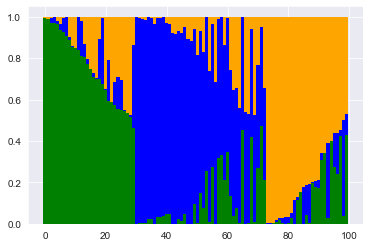

In [37]:
# sorted_ind = reorder(q_true)
# q_sorted = q_true[sorted_ind,:]
# colors = ['green','blue','orange','red']
# ax = plt.axes()
# xdata = np.arange(N)
# bottom = np.zeros(N, dtype=float)
# for i, ydata in enumerate(q_sorted.T):
#     color = colors[i]
#     ax.bar(xdata, ydata, bottom=bottom, color=color, width=1.0, linewidth=0)
#     bottom += ydata

In [27]:
# β = 1
# γ = 1
# α = .5
# σ_α = .01
# K = 3

In [32]:
# θ, q, Z = sample_prior()

In [1]:
## burn-in
# for _ in range(1000):
#     θ, q, Z, α = Gibbs_next(θ, q, Z, α)

In [2]:
## collect posterior data
# qs = []
# for _ in range(10):
#     θ, q, Z, α = Gibbs_next(θ, q, Z, α)
#     if _ % 10 == 0:
#         qs.append(q)


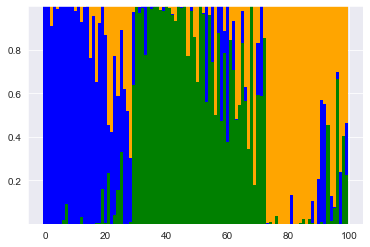

In [35]:
# qs = np.array(qs)
# q_pred = np.mean(qs, axis=0)
# q_pred = q_pred[sorted_ind,:]
# colors = ['green','blue','orange','red']
# ax = plt.axes()
# xdata = np.arange(N)
# bottom = np.zeros(N, dtype=float)
# for i, ydata in enumerate(q_pred.T):
#     color = colors[i]
#     ax.bar(xdata, ydata, bottom=bottom, color=color, width=1.0, linewidth=0)
#     bottom += ydata